In [29]:
import os 
if os.environ.get("preamble_run", None) is not None: 
    print("Not re-runnning preamble")
else: 
    %run -i ../preamble.py

Not re-runnning preamble


In [30]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns


In [31]:
def prettify_run_name(run):
    parts = run.split("_")
    prettified = []
    for i in range(0, len(parts), 2):
        if i + 1 < len(parts):
            param = parts[i]
            value = parts[i + 1].replace("x", ".")
            if param == "no": 
                prettified.append(f"no {value}")
            else:
                prettified.append(f"{param}={value}")

    return " | ".join(prettified)

def clean_run_name(run):
    base_name =  run.split("__")[1]
    return prettify_run_name(base_name)

def clean_and_unify_run(run, logs): 
    cleaned_run_name = clean_run_name(run)
    
    re_run_idx = 1
    run = cleaned_run_name
    while run in logs:
        run = f"{cleaned_run_name} [{re_run_idx}]"
        re_run_idx += 1
    return run


In [32]:
data_dir = "./data"
timestamp = None #"1771279779"
data = dict()
log_names = set()
model_paths = dict()

for run in os.listdir(data_dir):
    if timestamp is not None and not run.endswith(timestamp):
        print("Skipping", run)
        continue

    run_name = clean_and_unify_run(run, data)
    data[run_name] = dict()
    model_paths[run_name] = f"td3:models/td3/{run}.model"
    for file in os.listdir(os.path.join(data_dir, run)):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(data_dir, run, file))
            log_name = file[:-4].replace("-", "/")
            data[run_name][log_name] = df
            log_names.add(log_name)

In [33]:
runs = sorted(data.keys())
cmap = plt.get_cmap("tab10")
run_colors = {run: cmap(i) for i, run in enumerate(runs)}

In [34]:
print("Runs found:")
for run in runs: 
    print(f"  {run}")

Runs found:
  pn=0.2 | sp=1
  pn=0.2 | sp=1 | no strong-opp
  rnd=0 | pn=0.2
  rnd=0.5-1 | sp=1
  rnd=0.5-1 | sp=1 | no strong-opp
  rnd=0.5-1 | sp=1 | pr=0.5-0.4
  rnd=1-0 | sp=1
  rnd=1-1 | sp=1
  sp=0
  sp=1
  sp=1 | reuse=1


In [35]:
print("Available logs:")
for log in sorted(log_names):
    print(f"  {log}")

Available logs:
  charts/SPS
  charts/env_step
  charts/extrinsic_reward
  charts/intrinsic_reward
  charts/mean_episode_length
  charts/n_opponents
  charts/opponent_elo
  charts/player_elo
  charts/pr_beta
  eval/current/acum_reward
  eval/current/draw_rate
  eval/current/lose_rate
  eval/current/win_rate
  eval/strong/acum_reward
  eval/strong/draw_rate
  eval/strong/lose_rate
  eval/strong/win_rate
  eval/weak/acum_reward
  eval/weak/draw_rate
  eval/weak/lose_rate
  eval/weak/win_rate
  losses/actor_loss
  losses/qf1_loss
  losses/qf1_values
  losses/qf2_loss
  losses/qf2_values
  losses/qf_loss
  losses/rnd_loss
  rnd/extrinsic_reward_replay
  rnd/intrinsic_reward_replay
  rnd/total_reward_replay
  self_play/n_opponents
  self_play/opponent_elo
  self_play/opponent_player_num_max
  self_play/opponent_player_num_median
  self_play/opponent_player_num_min
  self_play/player_elo


In [36]:
def plot_log(log_name, ax, smoothing_window=100, less_smooth_window=10, alpha=0.2):
    for run in data:
        if log_name in data[run]:
            df = data[run][log_name]
            less_smoothed_value = df["value"].rolling(window=less_smooth_window, center=True).mean()
            smoothed_value = df["value"].rolling(window=smoothing_window, center=True).mean()
            ax.plot(df["step"], less_smoothed_value, label=run, color=run_colors[run], alpha=alpha)
            ax.plot(df["step"], smoothed_value, label=run, color=run_colors[run])

In [37]:
opponent_eval = [l for l in log_names if "eval/" in l]
opponents = set([l.split("/")[1] for l in opponent_eval])

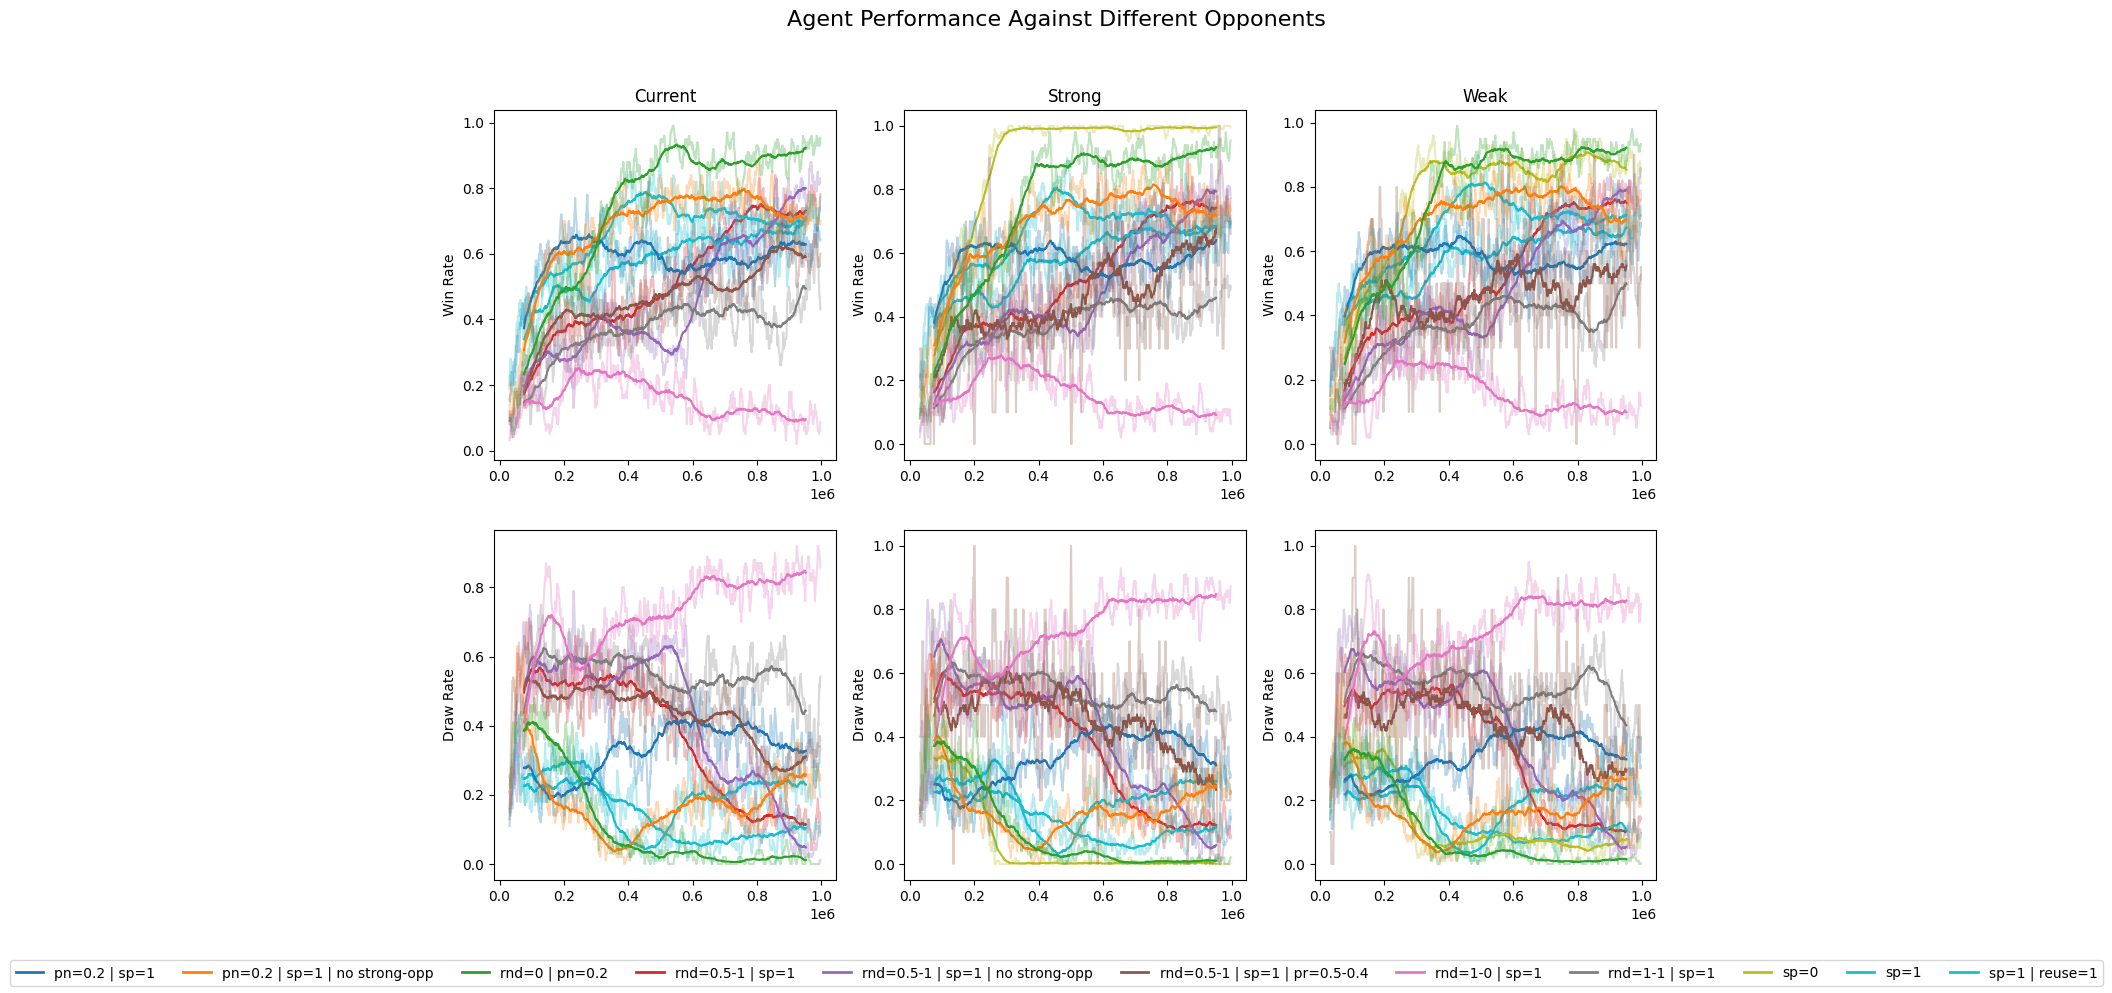

In [38]:
opponent_metrics = ["win_rate", "draw_rate"]
# opponent_metrics = ["win_rate", "lose_rate", "draw_rate"]

fig, axs = plt.subplots(len(opponent_metrics), len(opponents), figsize=(len(opponents)*5, len(opponent_metrics)*5))
fig.suptitle("Agent performance against different opponents".title(), fontsize=16)

for opponent_idx, opponent in enumerate(sorted(opponents)):
    if len(opponent_metrics) == 1:
        axs[opponent_idx].set_title(opponent.title())
    else:
        axs[0, opponent_idx].set_title(opponent.title())

    metric_axs = [axs[opponent_idx]] if len(opponent_metrics) == 1 else axs[:, opponent_idx]
    for metric, ax in zip(opponent_metrics, metric_axs):
        ax.set_ylabel(metric.replace("_", " ").title())
        plot_log(f"eval/{opponent}/{metric}", ax, smoothing_window=100, less_smooth_window=10, alpha=0.3)
        
handles = [plt.Line2D([0], [0], color=run_colors[run], lw=2) for run in runs]

fig.legend(handles, runs, loc="lower center", ncol=len(runs))
# fig.legend(runs, loc="lower center", ncol=len(data), )

In [39]:
self_play_logs = [
    "self_play/player_elo",
    "self_play/opponent_elo",
    "self_play/n_opponents",
    "self_play/opponent_player_num_max",
    "self_play/opponent_player_num_median",
    "self_play/opponent_player_num_min",
]

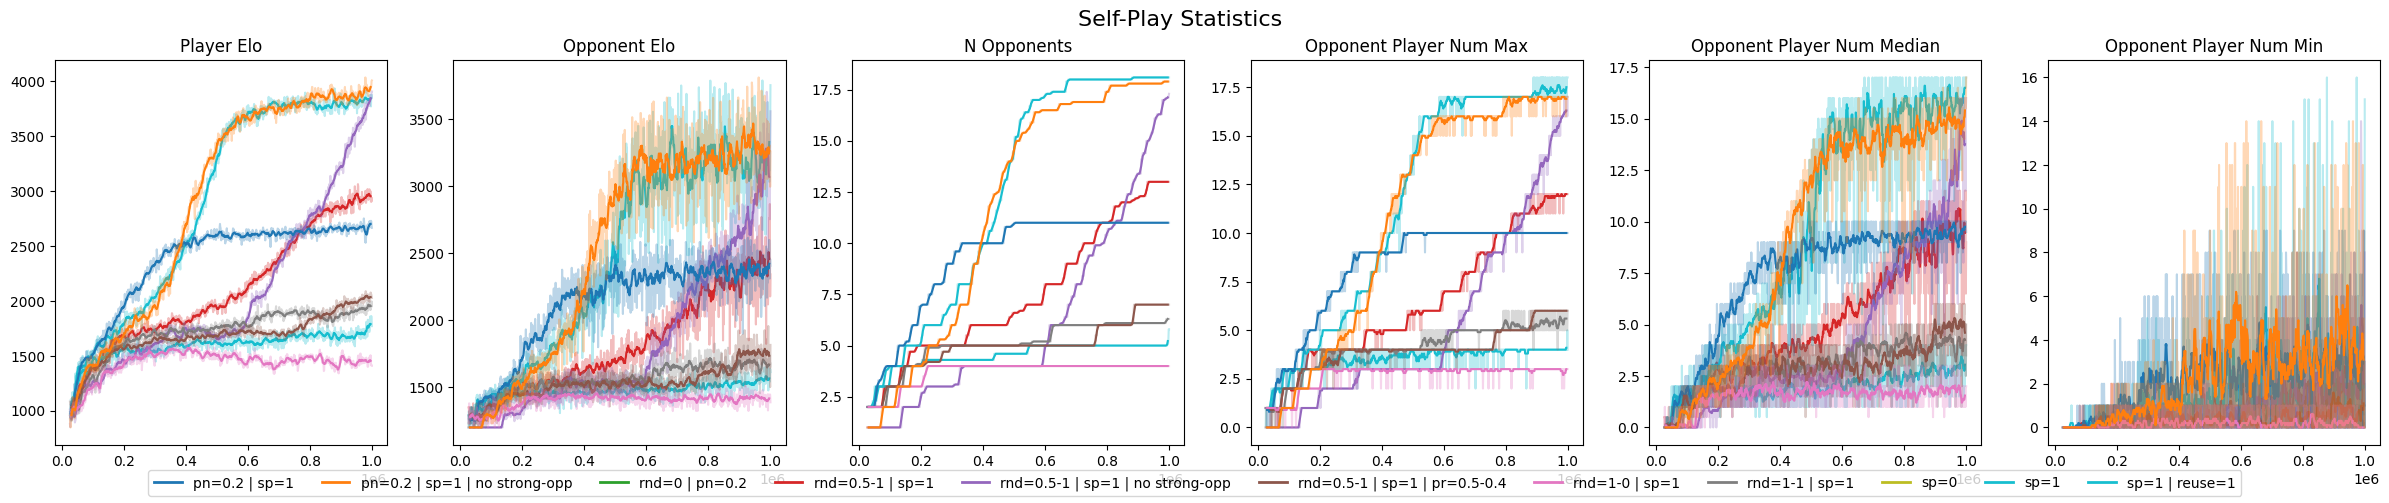

In [40]:
fig, axs = plt.subplots(1, len(self_play_logs), figsize=(len(self_play_logs)*5, 5))
fig.suptitle("Self-play statistics".title(), fontsize=16)

for idx, self_play_log in enumerate(self_play_logs):
    axs[idx].set_title(self_play_log.split("/")[1].replace("_", " ").title())

    # ax.set_ylabel(metric.replace("_", " ").title())
    plot_log(self_play_log, axs[idx], smoothing_window=10, less_smooth_window=1, alpha=0.3)
        
handles = [plt.Line2D([0], [0], color=run_colors[run], lw=2) for run in runs]

fig.legend(handles, runs, loc="lower center", ncol=len(runs))
# fig.legend(runs, loc="lower center", ncol=len(data), )

In [41]:
from src.td3.algorithm.evaluation import run_evaluation, run_evaluation_multiple_runs
from hockey.hockey_env import Mode

player_paths = [model_paths[run] for run in runs]
player_paths = player_paths + ["weak_opponent", "strong_opponent"]
n_eval_episodes = 10

results = run_evaluation_multiple_runs(player_paths, n_episodes=n_eval_episodes, render=False, seed=42, hockey_mode=Mode.NORMAL)

Loaded model from models/td3/HockeyOne-v0__pn_0x2_sp_1__42__1771317357.model
Loaded model from models/td3/HockeyOne-v0__pn_0x2_sp_1_no_strong-opp__42__1771317357.model
Loaded model from models/td3/HockeyOne-v0__rnd_0_pn_0x2__42__1771087868.model
Loaded model from models/td3/HockeyOne-v0__rnd_0x5-1_sp_1__42__1771317357.model
Loaded model from models/td3/HockeyOne-v0__rnd_0x5-1_sp_1_no_strong-opp__42__1771400668.model
Loaded model from models/td3/HockeyOne-v0__rnd_0x5-1_sp_1_pr_0x5-0x4__42__1771584430.model
Loaded model from models/td3/HockeyOne-v0__rnd_1-0_sp_1__42__1771317357.model
Loaded model from models/td3/HockeyOne-v0__rnd_1-1_sp_1__42__1771317357.model
Loaded model from models/td3/HockeyOne-v0__sp_0__42__1771317357.model
Loaded model from models/td3/HockeyOne-v0__sp_1__42__1771317357.model
Loaded model from models/td3/HockeyOne-v0__sp_1_reuse_1__42__1771317357.model


Evaluating runs: 100%|██████████| 13/13 [00:25<00:00,  2.00s/it]


In [42]:
scores = {}
all_player_metrics = ["win_rate", "draw_rate", "lose_rate"]
# all_player_metrics = ["win_rate"]
for metric in all_player_metrics: 
    metric_results = []
    for player in player_paths: 
        player_results = results[player]
        def win_rate_for_opponent(opponent):
            if opponent not in player_results:
                return 0.0
            else: 
                return results[player][opponent][metric]
        metric_results.append([win_rate_for_opponent(opponent) for opponent in player_paths])
    scores[metric] = metric_results

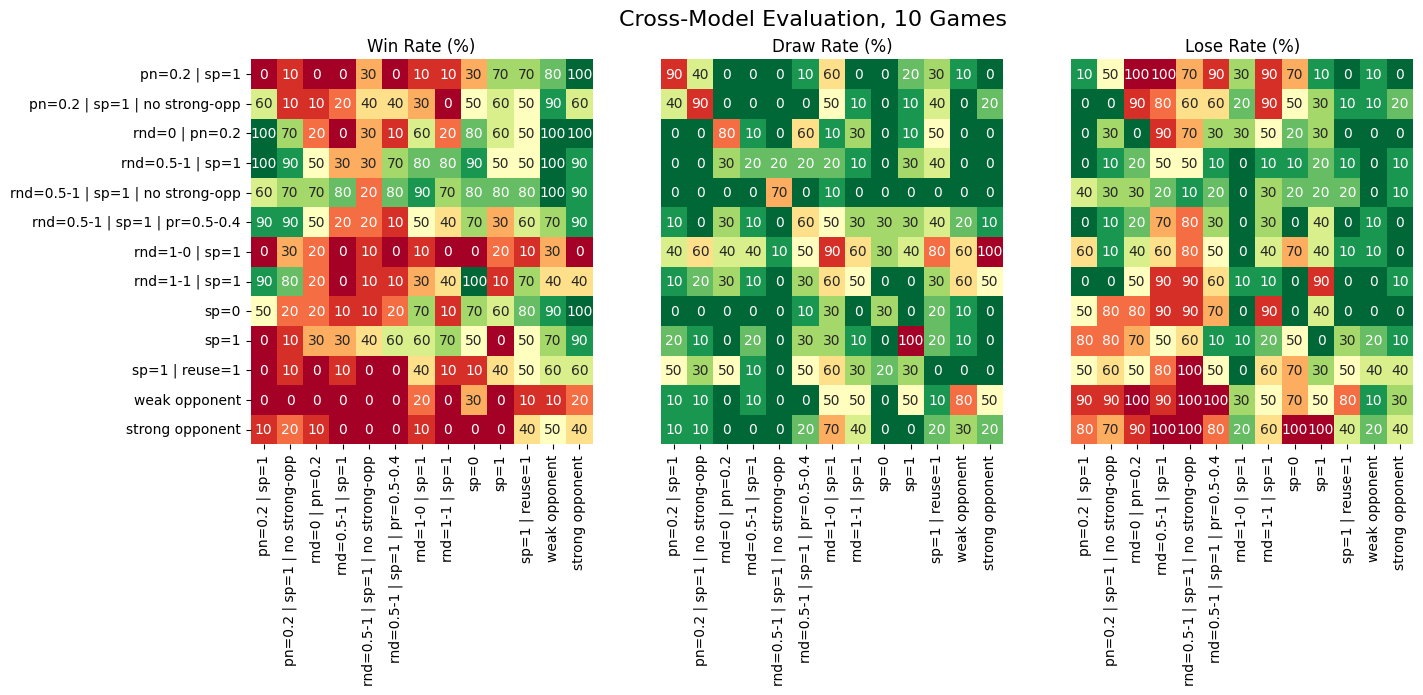

In [43]:
import numpy as np

# Convert win_rates to numpy array for better heatmap handling
fig, axs = plt.subplots(1, len(all_player_metrics), figsize=(len(all_player_metrics)*5, 5))
eval_run_names = runs + ["weak opponent", "strong opponent"]

for i, metric in enumerate(all_player_metrics): 
    ax = axs if len(all_player_metrics) == 1 else axs[i]
    win_rates_array = np.array(scores[metric])
    win_rates_array = (win_rates_array*100).astype(np.int32)
    # win_rates_array[np.diag_indices_from(win_rates_array)] = np.nan # hide out diagonal because playing against itself is not meaningful

    cmap = "RdYlGn" if metric == "win_rate" else "RdYlGn_r"
    sns.heatmap(win_rates_array, cbar = False, annot=True, fmt=".0f", cmap=cmap, ax=ax, xticklabels=eval_run_names, yticklabels=[] if i > 0 else eval_run_names, )
    ax.set_title(metric.replace("_", " ").title() + " (%)")

fig.suptitle(f"Cross-model evaluation, {n_eval_episodes} games".title(), fontsize=16)
None